In [3]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np

In [4]:
# Load the pre-trained Haar Cascade XML file for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
# Convert the face detection code into a function that takes an image as input and returns the resized faces
def detect_and_resize_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    resized_faces = []
    
    for (x, y, w, h) in faces:
        face_roi = image[y:y+h, x:x+w]
        resized_face = cv2.resize(face_roi, (48, 48))
        resized_faces.append(resized_face)
    
    return resized_faces

In [28]:

def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Create an instance of the AlexNet model
    model = AlexNet()

    # Load the pre-trained weights (if available) for the AlexNet model
    model.load_state_dict(torch.load('models/alexnet_model_30epochs.pth'))

    # Pass the resized faces through the AlexNet model and get the predictions
    with torch.no_grad():
        resized_faces = detect_and_resize_faces(image)
        face_predictions = []
        for resized_face in resized_faces:
            # Convert the resized face to a PyTorch tensor
            tensor_face = torch.from_numpy(resized_face).permute(2, 0, 1).unsqueeze(0).float() / 255.0

            # Pass the tensor through the AlexNet model
            predictions = model(tensor_face)

            # Apply argmax to retrieve the index of the class with the highest score
            predicted_class_index = torch.argmax(predictions)
            face_predictions.append(predicted_class_index.item())

    class_labels = {
        0: "angry",
        1: "disgust",
        2: "fear",
        3: "happy",
        4: "neutral",
        5: "sad",
        6: "surprise"
    }

    result = class_labels[predicted_class_index.item()]

    # Detect and resize faces
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_faces = detect_and_resize_faces(image)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, len(resized_faces) + 2, figsize=(12, 4))

    # Plot the original image
    axes[0].imshow(image_rgb)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Plot the resized faces
    for i, resized_face in enumerate(resized_faces):
        resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB) 
        axes[i+1].imshow(resized_face)
        axes[i+1].axis('off')
        axes[i+1].set_title(f'Face Detected')

    # Add text image
    result = result.upper()  # Convert result to uppercase
    text = "Result: " + result
    text_image = np.ones((100, 500, 3), dtype=np.uint8) * 255  # White background
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)  # Get text size
    text_x = (text_image.shape[1] - text_size[0]) // 2  # Calculate x position for center alignment
    text_y = (text_image.shape[0] + text_size[1]) // 2  # Calculate y position for center alignment
    cv2.putText(text_image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    axes[-1].imshow(text_image)
    axes[-1].axis('off')
    axes[-1].set_title('Result:')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()



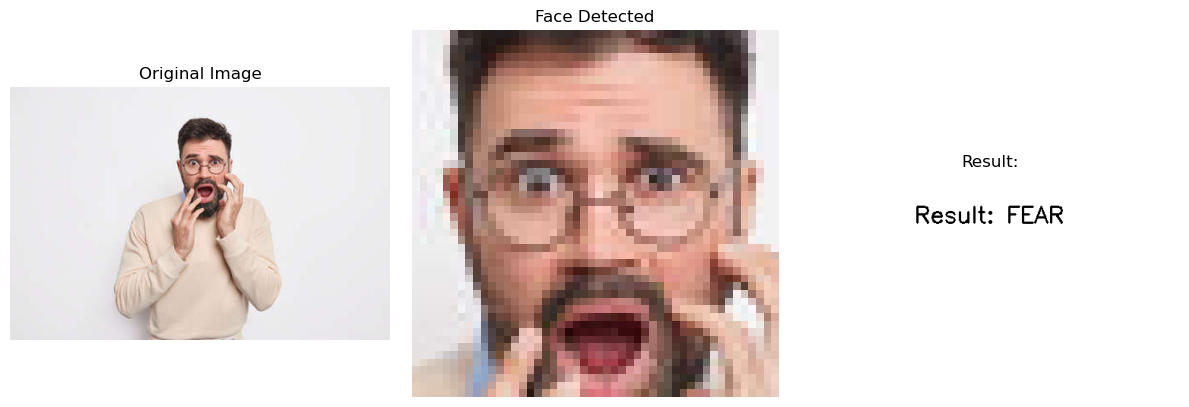

In [29]:
# Usage
image_path = 'imagen_tests/test1.jpg'
process_image(image_path)

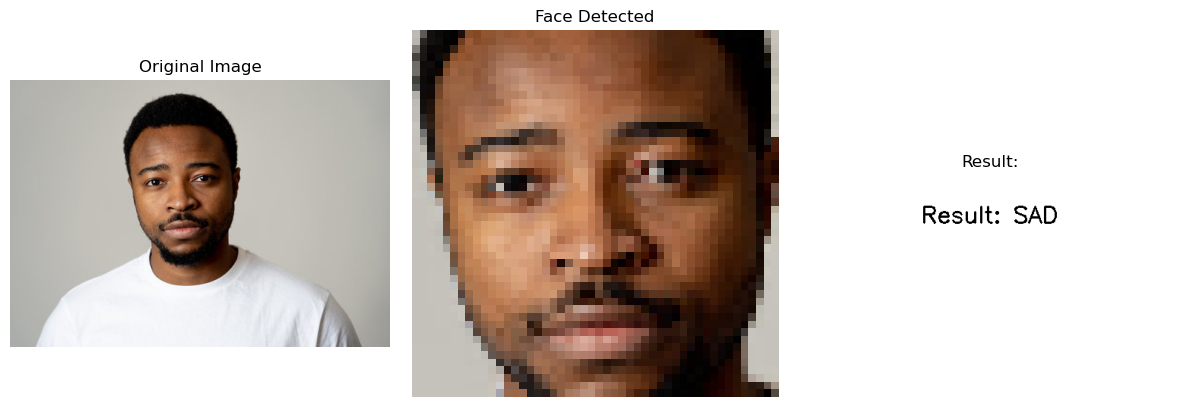

In [30]:
# Usage
image_path = 'imagen_tests/test2.jpg'
process_image(image_path)

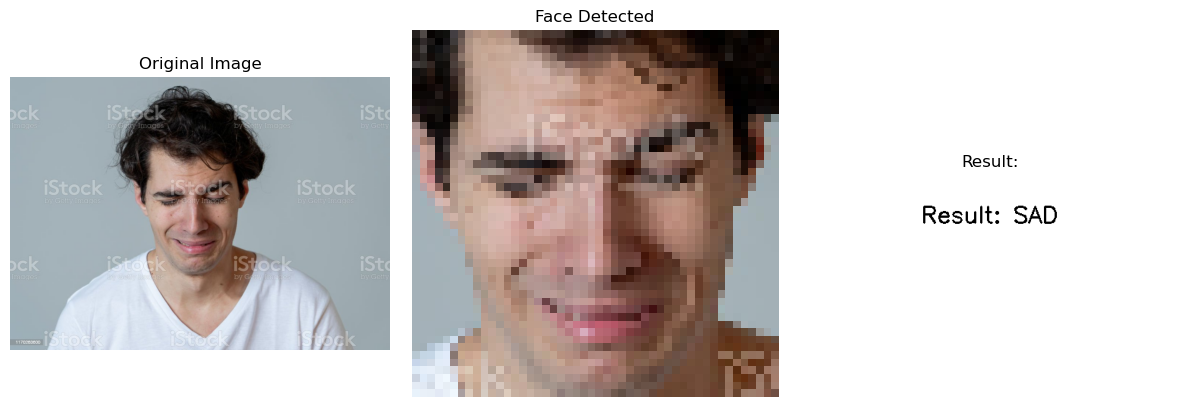

In [33]:
# Usage
image_path = 'imagen_tests/test3.jpg'
process_image(image_path)

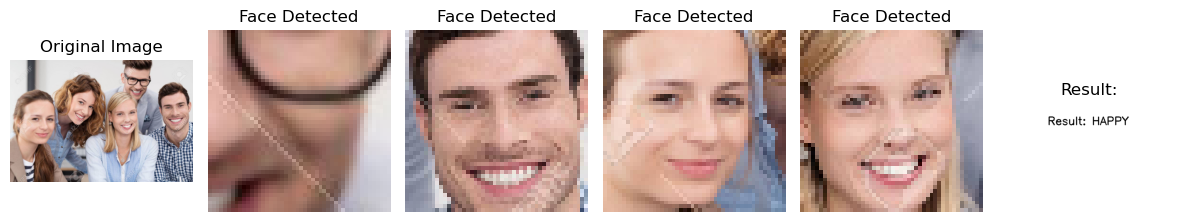

In [34]:
# Usage
image_path = 'imagen_tests/test4.jpg'
process_image(image_path)

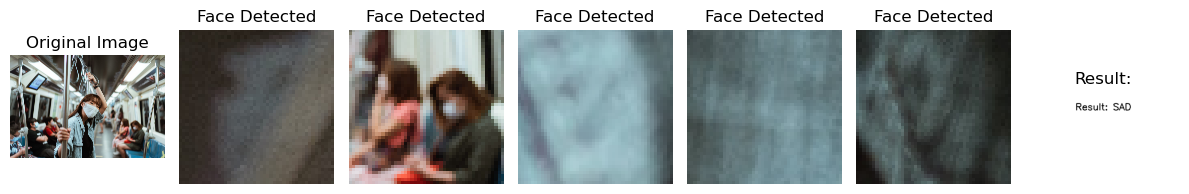

In [35]:
# Usage
image_path = 'imagen_tests/test5.jpg'
process_image(image_path)